Reading Data from file

In [4]:
import csv
import json
from nltk.tokenize import TweetTokenizer

def read_hate_tweets (annofile, jsonfile):
    """Reads in hate speech data."""
    all_data = {}
    annos = {}
    with open(annofile) as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        for row in csvreader:
            if row[0] in annos:
                # if duplicate with different rating, remove!
                if row[1] != annos[row[0]]:
                    del(annos[row[0]])
            else:
                annos[row[0]] = row[1]

    tknzr = TweetTokenizer()
                
    with open(jsonfile) as jsonfile:
        for line in jsonfile:
            twtjson = json.loads(line)
            twt_id = twtjson['id_str']
            if twt_id in annos:
                all_data[twt_id] = {}
                all_data[twt_id]['offensive'] = "nonoffensive" if annos[twt_id] == 'none' else "offensive"
                all_data[twt_id]['text_tok'] = tknzr.tokenize(twtjson['text'])

    # split training and test data:
    all_data_sorted = sorted(all_data.items())
    items = [(i[1]['text_tok'],i[1]['offensive']) for i in all_data_sorted]
    splititem = len(all_data)-3250
    train_dt = items[:splititem]
    test_dt = items[splititem:]
    print('Training data:',len(train_dt))
    print('Test data:',len(test_dt))

    return(train_dt,test_dt)

TWEETS_ANNO = '../Data/NAACL_SRW_2016.csv'
TWEETS_TEXT = '../Data/NAACL_SRW_2016_tweets.json'

(train_data,test_data) = read_hate_tweets(TWEETS_ANNO,TWEETS_TEXT)


Training data: 12896
Test data: 3250


Naive Bayes Classifier Class

In [5]:
class NaiveBayes(object):
    C=[] # Classes : It is list of classes in dataset
    V=[] # Vocabulary : It is list of unique tokens in dataset
    log_prior = {} # It stores log_prior wrt to class, eg: {'class1':value,'class2':value,....}
    log_likelihood = {} # It stores log_likelihood wrt to class, eg: {'class1':{word1:value,word2:value,..},'class2':{},....}
    
    def __init__(self):
        self.tp = 0 # True Positive 
        self.tn = 0 # True Negative
        self.fp = 0 # False Positive
        self.fn = 0 # False Negative

    def predict(self, x):
        
        """Predicts the class for a document.

        Args:
            x: A document, represented as a list of words.

        Returns:
            The predicted class, represented as a string.
        """
        
        sum_ = {} # Variable to store sum of log probability as { 'class1': value, 'class2': value , ....}
        
        x = remove_unknown(self.V,x) # removes words which are not present in Vocabulary but in test document
        
        
        #x = [word.lower() for word in x] 
        
        
        for cl in self.C:
            tot = self.log_prior[cl]
            for word in x:
                if word in self.V:
                    tot=tot+self.log_likelihood[cl][word]
            sum_[cl] = tot
            tot=0
        
        if(len(sum_)>0):
            return max(sum_.items(), key=operator.itemgetter(1))[0]
        else:
            return None #Returns None if remove_unkown() returns a empty list
        
        
        
    @classmethod
    def train(cls, data, k=1):
        """Train a new classifier on training data using maximum
        likelihood estimation and additive smoothing.

        Args:
            cls: The Python class representing the classifier.
            data: Training data.
            k: The smoothing constant.

        Returns:
            A trained classifier, an instance of `cls`.
        """
        
        num_of_docs = len(data) # total number of tweets in our case
        cls.C = set([word[1] for word in data]) # set of classes
        cls.V = vocab(data) # set of unique words in training data
        
        
        #cls.V = remove_stop_words(cls.V)
        #cls.V = [word.lower() for word in cls.V]
        
        
        words_in_class = {} # It is dictionary which contain tokens and vocabulary wrt class
                            # eg: { 'class1' : [[list of token],[list of unique tokens or vocabulary]], 'class2':[[],[]],...}
        for cl in cls.C:
            num_of_docs_in_c = count_for_class(data,cl)
            cls.log_prior[cl] = math.log(num_of_docs_in_c/num_of_docs)
            words_in_class[cl] = (vocab_for_class(data,cl))
            
            
            #words_in_class[cl][0] = remove_stop_words(words_in_class[cl][0])
            #words_in_class[cl][1] = remove_stop_words(list(words_in_class[cl][1]))
            #words_in_class[cl][0] = [word.lower() for word in words_in_class[cl][0]]
            #words_in_class[cl][1] = [word.lower() for word in words_in_class[cl][1]]
            
            
            count = {}
            cls.log_likelihood[cl] = {}
            for word in cls.V:
                count[word] = words_in_class[cl][0].count(word)
                vc_class_doc = len(words_in_class[cl][0]) + k*len(cls.V)
                cls.log_likelihood[cl][word] = math.log((count[word]+k)/(vc_class_doc))
        return cls()

    
    

def count_for_class(data,class_name):
    '''
    This function returns number of docs(tweets) with respect
    to a given input class.

    Parameters
    ----------
    data : List of docs with class
        DESCRIPTION.
    class_name : string.

    Returns
    -------
    count_of_class : int 

    '''
    count_of_class = 0
    for datum in data:
        if(datum[1] == class_name):
            count_of_class+=1
    return count_of_class



def vocab_for_class(data,class_name):
    '''
    This function creates vocabulary for a particular class and returns
    a list of words in a class and set of unique words in that class

    Parameters
    ----------
    data : List of docs with class
        DESCRIPTION.
    class_name : string.


    Returns
    -------
    list
        

    '''
    vocab = []
    for word in data:
        if(word[1] == class_name):
            vocab+=word[0]
    return [vocab,set(vocab)]


def vocab(data):
    '''
    This function creates vocabulary set for a given Document

    Parameters
    ----------
    data : list of documents with labelled classes

    Returns
    -------
    set of unique words in set of Documents

    '''
    vocab = []
    for word in data:
        vocab+=word[0]
    return set(vocab)

def remove_unknown(train_vocab,test_vocab):
    '''
    It removes the words which are present in testing set but not
    in training set.

    Parameters
    ----------
    train_vocab : vocabulary of training set
    test_vocab : vocabulary of testing set

    Returns
    -------
    test_vocab : modified testing vocabulary

    '''
    x = set(test_vocab)
    x = set(train_vocab).intersection(x)
    for word in test_vocab:
        if(word not in x):
            test_vocab = list(filter(lambda w: w != word, test_vocab))
    return test_vocab



Evaluation Functions

In [6]:
import csv,math,string
import json,operator,random  
def accuracy(classifier, data):
    """Computes the accuracy of a classifier on reference data.


    Args:
        classifier: A classifier.
        data: Reference data.

    Returns:
        The accuracy of the classifier on the test data, a float.
    """
    
    for d in data:
        tweet = d[0]
        actual = d[1]
        predicted = classifier.predict(tweet)
        if ( predicted is None):
            continue 
           
        # Some document(tweets) might be empty after removing unknown and stop words, in that case predict() returns None
        # and continue to next document(tweet)
        
        if(actual == predicted):
            if(predicted == 'offensive'):
                classifier.tp+=1
            else:
                classifier.tn+=1
        else:
            if(predicted == 'offensive'):
                classifier.fp+=1
            else:
                classifier.fn+=1
    return (classifier.tp+classifier.tn)/(classifier.tp+classifier.tn+classifier.fn+classifier.fp)

def f_1(classifier, data):
    """
     Computes the F_1-score of a classifier on reference data.
    

    Args:
        classifier: A classifier.
        data: Reference data.

    Returns:
        The F_1-score of the classifier on the test data, a float.
    """
    
   
   
    precision = classifier.tp/(classifier.tp+classifier.fp)
    recall  = classifier.tp/(classifier.tp+classifier.fn)
    f1 = (2*precision*recall)/(precision+recall)
    return f1

In [7]:
acc = [] # accuracy list
f1 = [] #f1 score list
klist = [i/10 for i in range(1,100)] # list of k values ranges 0 to 1 with step of 0.01
for k in klist:
    nb = NaiveBayes.train(train_data,k)
    acc.append(accuracy(nb, test_data))
    f1.append(f_1(nb,test_data))

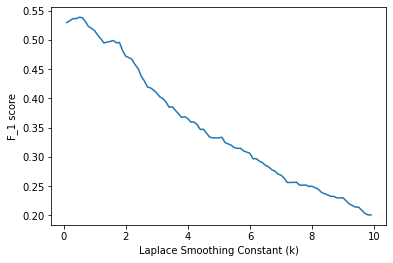

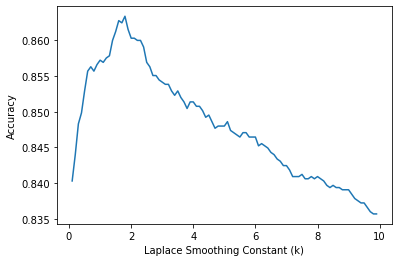

In [9]:
import matplotlib.pyplot as plt
plt.plot(klist,f1)
plt.ylabel('F_1 score')
plt.xlabel('Laplace Smoothing Constant (k)')
plt.show()
plt.plot(klist,acc)
plt.ylabel('Accuracy')
plt.xlabel('Laplace Smoothing Constant (k)')
plt.show()